### Car Tracking project by Emil Wåreus


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import time
from skimage.feature import hog 

## Extract Features


In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features

def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel() 
                            
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [13]:
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
   
        file_features.append(spatial_features)
    if hist_feat == True:
         
        hist_features = color_hist(feature_image, nbins=hist_bins)

        file_features.append(hist_features)
    if hog_feat == True:
   
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
         
        file_features.append(hog_features)
    return file_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = []
    n_img = len(imgs)
    i = 0
    for file_p in imgs:
        i += 1
        print (i, end="\r")
        file_features = []
        image = cv2.imread(file_p) 
        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, 
                                     spatial_feat, 
                                     hist_feat, 
                                     hog_feat, 
                                     hist_bins, 
                                     orient, 
                                     pix_per_cell,
                                     cell_per_block, 
                                     hog_channel)
        
        
        features.append(np.concatenate(file_features))
        '''
        feature_image=cv2.flip(feature_image,1) 
        file_features = img_features(feature_image, 
                                     spatial_feat, 
                                     hist_feat, 
                                     hog_feat, 
                                     hist_bins, 
                                     orient, 
                                     pix_per_cell, 
                                     cell_per_block, 
                                     hog_channel)
        
       
        features.append(np.concatenate(file_features))
         '''
    return features 

## Lets train a classifier!! 

In [14]:
#Load the data
import glob
cars = []
none_cars = []
for img in glob.glob('*data/non-vehicles/*/*.png'):
    none_cars.append(img)
    
    
for img in glob.glob("data/vehicles/*/*.png"):
    cars.append(img)


print("Number of cars : ", len(cars))
print("Number of none-cars : ", len(none_cars))

Number of cars :  8792
Number of none-cars :  8968


In [ ]:
color_space = 'YUV' 
orient = 11
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = 'ALL'
spatial_size = (16, 16) 
hist_bins = 32    
spatial_feat = False
hist_feat = False
hog_feat = True 

car_features = extract_features(cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)

none_car_features = extract_features(none_cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)

print("Number of cars : ", len(car_features))
print("Number of none-cars : ", len(none_car_features))


22

C:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of cars :  8792
Number of none-cars :  8968


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import sklearn

print(len(car_features) + len(none_car_features))


SVC = LinearSVC(loss = 'hinge') 
#Building a classifier:

X = np.vstack((car_features, none_car_features)).astype(np.float64)
print(len(X))
Y = np.hstack((np.ones(len(car_features)), np.zeros(len(none_car_features))))
print(len(Y))
X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=22)
#print(len(scaled_X))
#train batch
SVC.fit(X_train, Y_train)
print(" Done")
'''
for i in range(1,17):
    X = np.vstack((car_features[set_size*(i-1):set_size*i], not_cars_features[set_size*(i-1):set_size*i])).astype(np.float64)
    #print(len(X))
    Y = np.hstack((np.ones(len(car_features[set_size*(i-1):set_size*i])), np.zeros(len(not_cars_features[set_size*(i-1):set_size*i]))))
    #print(len(Y))
    X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
    scaled_X = X_scaler.transform(X) # Apply the scaler to X
    X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.0, random_state=22)
    #print(len(scaled_X))
    #train batch
    SVC.fit(scaled_X, Y_train)
    print(i, " Done")
'''

17760
17760
17760


In [ ]:
#Train support vector Machine
print("Accuracy of SVC : ", round(SVC.score(X_test, Y_test), 5))


In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

## Sliding Window

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy



def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
def single_img_features(img, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [10]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space, 
                    spatial_size, hist_bins, 
                    hist_range, orient, 
                    pix_per_cell, cell_per_block, 
                    hog_channel, spatial_feat, 
                    hist_feat, hog_feat):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Testing the classifier 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


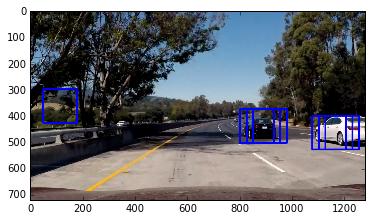

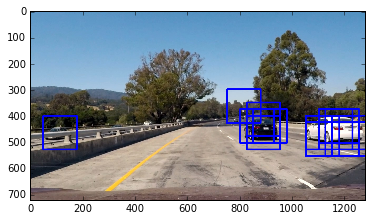

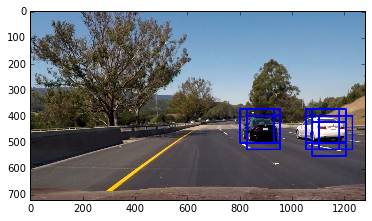

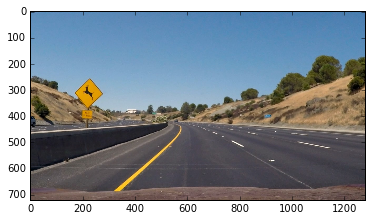

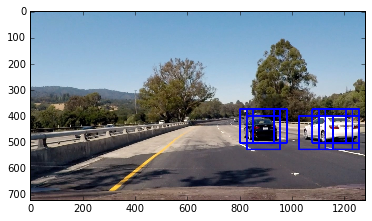

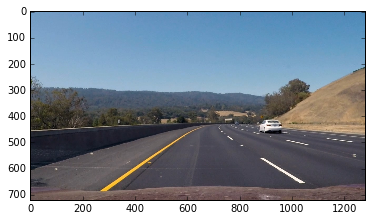

In [11]:
for image_path in glob.glob('test_images/test*.jpg'):
    img = cv2.imread(image_path)
    img_out = img.copy()
    in_windows = slide_window(img, x_start_stop = [None, None], y_start_stop = [300, 640],
                             xy_window = (128, 128), xy_overlap = (0.8, 0.8))
    hot = []
    hot += (search_windows(img = img, 
                           windows = in_windows, 
                           clf = SVC, 
                           scaler = X_scaler, 
                           color_space=color_space,
                           spatial_size = spatial_size,
                           hist_bins = hist_bins,
                           hist_range = (0,256),
                           orient=orient, 
                           pix_per_cell=pix_per_cell,
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, 
                           spatial_feat = spatial_feat,
                           hist_feat = hist_feat,
                           hog_feat = hog_feat))
    
   
    
    img_w_boxes = draw_boxes(img_out, hot, color = (255, 0 , 0), thick = 5)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB))
    plt.show()

Great! The classifier works okay. Now we need to add a heat map to get rid of the multiple classifications and false positives. We need to add some other scaling as well since the last image didn't classify correctly

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


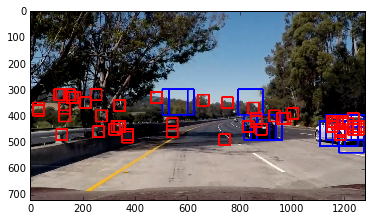

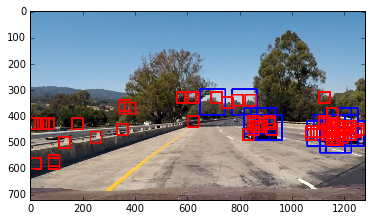

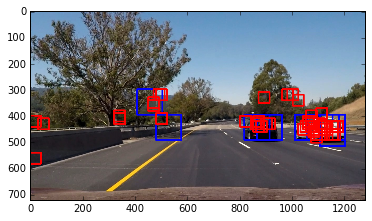

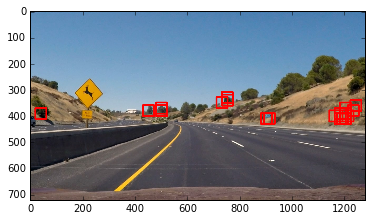

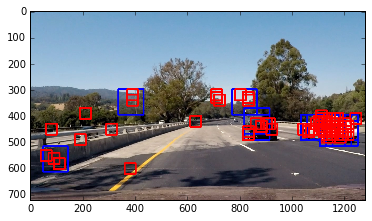

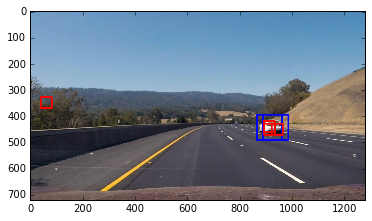

In [36]:
#Trying to get to classify to smaller cars by adding smaller boxes

for image_path in glob.glob('test_images/test*.jpg'):
    img = cv2.imread(image_path)
    img_out = img.copy()
    in_windows = slide_window(img, x_start_stop = [None, None], y_start_stop = [300, 640],
                             xy_window = (96, 96), xy_overlap = (0.75, 0.75))
    
    in_windows_small = slide_window(img, x_start_stop = [None, None], y_start_stop = [300, 640],
                             xy_window = (42, 42), xy_overlap = (0.75, 0.75))
    hot = []
    hot += (search_windows(img = img, 
                           windows = in_windows, 
                           clf = SVC, 
                           scaler = X_scaler, 
                           color_space=color_space,
                           spatial_size = spatial_size,
                           hist_bins = hist_bins,
                           hist_range = (0,256),
                           orient=orient, 
                           pix_per_cell=pix_per_cell,
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, 
                           spatial_feat = spatial_feat,
                           hist_feat = hist_feat,
                           hog_feat = hog_feat))
    
    
    hot_small = []
    hot_small += (search_windows(img = img, 
                           windows = in_windows_small, 
                           clf = SVC, 
                           scaler = X_scaler, 
                           color_space=color_space,
                           spatial_size = spatial_size,
                           hist_bins = hist_bins,
                           hist_range = (0,256),
                           orient=orient, 
                           pix_per_cell=pix_per_cell,
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, 
                           spatial_feat = spatial_feat,
                           hist_feat = hist_feat,
                           hog_feat = hog_feat))
    
   
    
    img_w_boxes = draw_boxes(img_out, hot, color = (255, 0 , 0), thick = 5)
    img_w_boxes = draw_boxes(img_w_boxes, hot_small, color = (0, 0 , 255), thick = 5)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB))
    plt.show()

In [72]:
#Lets make this a function: 

def get_boxes(img, 
               windows, 
               clf, 
               scaler, 
               color_space,
               spatial_size,
               hist_bins,
               hist_range,
               orient, 
               pix_per_cell,
               cell_per_block, 
               hog_channel, 
               spatial_feat,
               hist_feat,
               hog_feat):

    
    
    in_windows = slide_window(img, x_start_stop = [None, None], y_start_stop = [300, 640],
                             xy_window = (96, 96), xy_overlap = (0.75, 0.75))
    
    in_windows_small = slide_window(img, x_start_stop = [None, None], y_start_stop = [300, 640],
                             xy_window = (42, 42), xy_overlap = (0.75, 0.75))
    hot = []
    hot += (search_windows(img = img, 
                           windows = in_windows, 
                           clf = SVC, 
                           scaler = X_scaler, 
                           color_space=color_space,
                           spatial_size = spatial_size,
                           hist_bins = hist_bins,
                           hist_range = (0,256),
                           orient=orient, 
                           pix_per_cell=pix_per_cell,
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, 
                           spatial_feat = spatial_feat,
                           hist_feat = hist_feat,
                           hog_feat = hog_feat))


    hot_small = []
    hot_small += (search_windows(img = img, 
                           windows = in_windows_small, 
                           clf = SVC, 
                           scaler = X_scaler, 
                           color_space=color_space,
                           spatial_size = spatial_size,
                           hist_bins = hist_bins,
                           hist_range = (0,256),
                           orient=orient, 
                           pix_per_cell=pix_per_cell,
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, 
                           spatial_feat = spatial_feat,
                           hist_feat = hist_feat,
                           hog_feat = hog_feat))
    
    
    
    return (hot + hot_small)





In [73]:
from scipy.ndimage.measurements import label





def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        size = np.absolute(np.max(nonzerox)-np.min(nonzerox))*np.absolute(np.min(nonzeroy)-np.max(nonzeroy))
        
        #Filter size of box! 
        if(size > 3000):
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

    
def draw_heated_boxes(img, box_list, threshold = 2):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    
    return draw_labeled_bboxes(np.copy(img), labels)

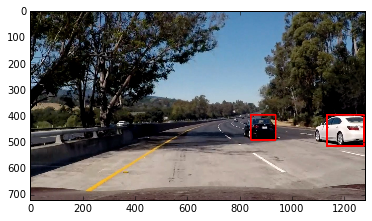

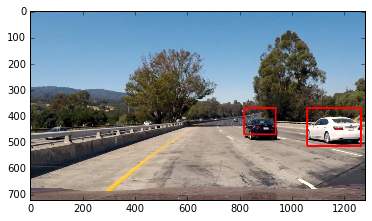

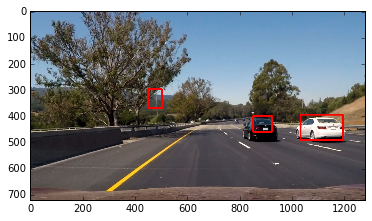

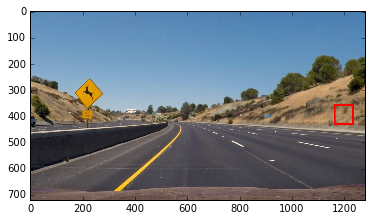

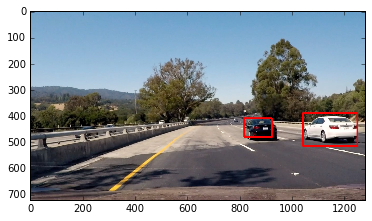

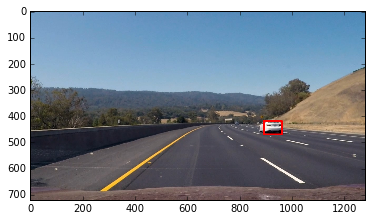

In [95]:
#Lets test with heat added:
i=1
for image_path in glob.glob('test_images/test*.jpg'):
    img = cv2.imread(image_path)
    img_out = img.copy()
    
    hot = get_boxes(img, 
                   windows = in_windows, 
                   clf = SVC, 
                   scaler = X_scaler, 
                   color_space=color_space,
                   spatial_size = spatial_size,
                   hist_bins = hist_bins,
                   hist_range = (0,256),
                   orient=orient, 
                   pix_per_cell=pix_per_cell,
                   cell_per_block=cell_per_block, 
                   hog_channel=hog_channel, 
                   spatial_feat = spatial_feat,
                   hist_feat = hist_feat,
                   hog_feat = hog_feat)
    
  
    img_w_boxes = draw_heated_boxes(img_out, hot, threshold=2)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB))
    plt.show()
    path=('output_images/test_w_boxes{}.jpg'.format(i))
    cv2.imwrite(path,img)
    i = i+1

Good Enough! 

In [94]:
#Make Video: 
def full_pipeline(img):
    img_out = img.copy()
    
    hot = get_boxes(img, 
                   windows = in_windows, 
                   clf = SVC, 
                   scaler = X_scaler, 
                   color_space=color_space,
                   spatial_size = spatial_size,
                   hist_bins = hist_bins,
                   hist_range = (0,256),
                   orient=orient, 
                   pix_per_cell=pix_per_cell,
                   cell_per_block=cell_per_block, 
                   hog_channel=hog_channel, 
                   spatial_feat = spatial_feat,
                   hist_feat = hist_feat,
                   hog_feat = hog_feat)

    
    img_w_boxes = draw_heated_boxes(img_out, hot, threshold=3)
   
    return img_w_boxes



from moviepy.editor import VideoFileClip

output_v = 'project_video_proc.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(full_pipeline)
%time clip.write_videofile(output_v, audio=False)


[MoviePy] >>>> Building video project_video_proc.mp4
[MoviePy] Writing video project_video_proc.mp4


100%|█████████▉| 1260/1261 [4:51:46<00:13, 13.81s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc.mp4 

CPU times: user 4h 51min 49s, sys: 3.07 s, total: 4h 51min 52s
Wall time: 4h 51min 47s
